In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
from scipy.signal import butter, filtfilt, freqz
from scipy.stats import pearsonr
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../../..')
from ld_utils import compute_eigs, get_data_sigma_norms
from up_down import get_up_down
from utils import get_result_path, load, save

In [3]:
session = 'Mary-Anesthesia-20160809-01'

## Load Neural Data Info

In [4]:
filename = fr'/om/user/eisenaj/ChaoticConsciousness/data/propofolPuffTone/{session}.mat'
print("Loading data ...")
start = time.process_time()
electrode_info, lfp_schema, session_info, spike_times, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo'], verbose=False)
spike_times = spike_times[0]
dt = lfp_schema['smpInterval'][0]
# T = lfp.shape[0]

# f = h5py.File(filename, 'r')
# airPuff_binary, audio_binary = get_binary_stimuli(f)

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
Data loaded (took 3.22 seconds)


## Load Results

In [5]:
correlations_results_dir = "/om/user/eisenaj/ChaoticConsciousness/results/propofol/correlations"
window = 2.5
stride = 2.5
correlations_result_path = get_result_path(correlations_results_dir, session, window, stride)
correlations_run_data = load(correlations_result_path)

In [6]:
correlations = correlations_run_data

In [7]:
VAR_results_dir = "/om/user/eisenaj/ChaoticConsciousness/results/propofol/VAR"
VAR_result_path = get_result_path(VAR_results_dir, session, window, stride)
VAR_run_data = load(VAR_result_path)

In [8]:
VAR = VAR_run_data['results']['all']

## Compare

In [9]:
VAR.head()

,eigs,A_mat,A_mat_with_bias,sigma_norms,sigma2_ML,AIC,window_locs,data_sigma_norms
0,"[0.7691946507384777, 0.7691946507384777, 0.719...","[[0.8343781094932042, 0.0958258736224859, 0.04...","[[-0.00321241738756414, -0.005885769248440647,...",0.001021,0.068905,-6685.577670,"[0, 2500]",0.199636
1,"[0.7867990538637615, 0.7867990538637615, 0.832...","[[0.782805386961231, 0.11612843515221853, 0.11...","[[-0.007393330710122945, -0.002014743283405777...",0.001497,0.079066,-6341.669870,"[2500, 5000]",0.226331
2,"[0.7900257422753438, 0.7900257422753438, 0.819...","[[0.7533357664610157, 0.135502465063974, 0.106...","[[0.0030266933043298365, -0.000729466346540240...",0.002138,0.082447,-6236.985569,"[5000, 7500]",0.164156
3,"[0.7973710328353877, 0.7973710328353877, 0.786...","[[0.7695555808437688, 0.15124839343503382, 0.0...","[[-0.019538228519091826, -0.014060050081772286...",0.001839,0.079565,-6325.950569,"[7500, 10000]",0.366895
4,"[0.7859718291246546, 0.7859718291246546, 0.810...","[[0.7579899143816323, 0.18930499472953471, -0....","[[0.0019640971261379856, -0.009078511616743836...",0.002162,0.082452,-6236.832541,"[10000, 12500]",0.257013


In [10]:
correlations.head()

,start_ind,start_time,end_ind,end_time,correlations,p_vals
0,0,0.0,2500,2.5,"[[1.0, 0.903087072269003, 0.780571796179143, 0...","[[0.0, 0.0, 0.0, 2.6774513824498127e-279, 2.37..."
1,2500,2.5,5000,5.0,"[[0.9999999999999999, 0.9085506182997449, 0.77...","[[0.0, 0.0, 0.0, 5.930745137105963e-237, 2.684..."
2,5000,5.0,7500,7.5,"[[1.0, 0.8700076442607931, 0.7281272776102967,...","[[0.0, 0.0, 0.0, 1.0398796603775902e-218, 6.25..."
3,7500,7.5,10000,10.0,"[[0.9999999999999997, 0.9196452196677776, 0.78...","[[0.0, 0.0, 0.0, 1.1275734897095271e-218, 2.77..."
4,10000,10.0,12500,12.5,"[[1.0, 0.8966717441888947, 0.7735741368761786,...","[[0.0, 0.0, 0.0, 5.367265537651682e-201, 2.222..."


In [12]:
num_rows = len(VAR)

matrix_correls = np.zeros((num_rows,))
matrix_p_vals = np.zeros((num_rows,))
for i in tqdm(range(len(VAR))):
    matrix_correls[i], matrix_p_vals[i] = pearsonr(correlations.correlations.iloc[i].T.flatten(), VAR.A_mat.iloc[i].flatten())

  0%|          | 0/2822 [00:00<?, ?it/s]

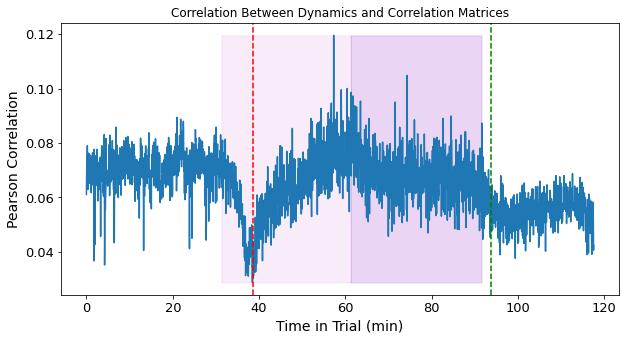

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(correlations.start_time/60, matrix_correls)
plt.xlabel("Time in Trial (min)", fontsize=14)
plt.ylabel("Pearson Correlation", fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title("Correlation Between Dynamics and Correlation Matrices")

min_val = matrix_correls.min()
max_val = matrix_correls.max()

ax = plt.gca()
ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], stride)/60, 
                                min_val, max_val, color='plum', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][0]}")
ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], stride)/60, 
                        min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 2 - dose = {session_info['drugDose'][1]}")

plt.axvline(session_info['eyesClose'][-1]/60 if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/60, linestyle='--', c='red', label="loss of consciousness")
plt.axvline(session_info['eyesOpen'][-1]/60 if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/60, linestyle='--', c='green', label="return of consciousness")

plt.show()